# Regression splines (Cherry blossom example) 

This example shows how to specify and fit a spline regression in Bambi. This example is based on [this example](https://github.com/pymc-devs/pymc-examples/blob/main/examples/splines/spline.ipynb) from the PyMC docs.

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
SEED = 7355608

## Load Cherry Blossom data

Richard McElreath popularized the Cherry Blossom dataset in the second edition of his excellent book Statistical Rethinking. This data represents the day in the year when the first bloom is observed for Japanese cherry blossoms between years 801 and 2015. In his book, Richard McElreath uses this dataset to introduce Basis Splines, or B-Splines in short.

Here we use Bambi to fit a linear model using B-Splines with the Cherry Blossom data. This dataset can be loaded with Bambi as follows:

In [3]:
data = bmb.load_data("cherry_blossoms")
data

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1210,2011,99.0,NaN,NaN,NaN
1211,2012,101.0,NaN,NaN,NaN
1212,2013,93.0,NaN,NaN,NaN
1213,2014,94.0,NaN,NaN,NaN


The variable we are interested in modeling is `"doy"`, which stands for Day of Year. Also notice this variable contains several missing value which are discarded next.

In [4]:
data = data.dropna(subset=["doy"]).reset_index(drop=True)
data.shape

(827, 5)

## Explore the data

Let's get started by creating a scatterplot to explore the values of `"doy"` for each year in the dataset.

In [5]:
# We create a function because this plot is going to be used again later
def plot_scatter(data, figsize=(10, 6)):
    _, ax = plt.subplots(figsize=figsize)
    ax.scatter(data["year"], data["doy"], alpha=0.4, s=30)
    ax.set_title("Day of the first bloom per year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Days of the first bloom")
    return ax

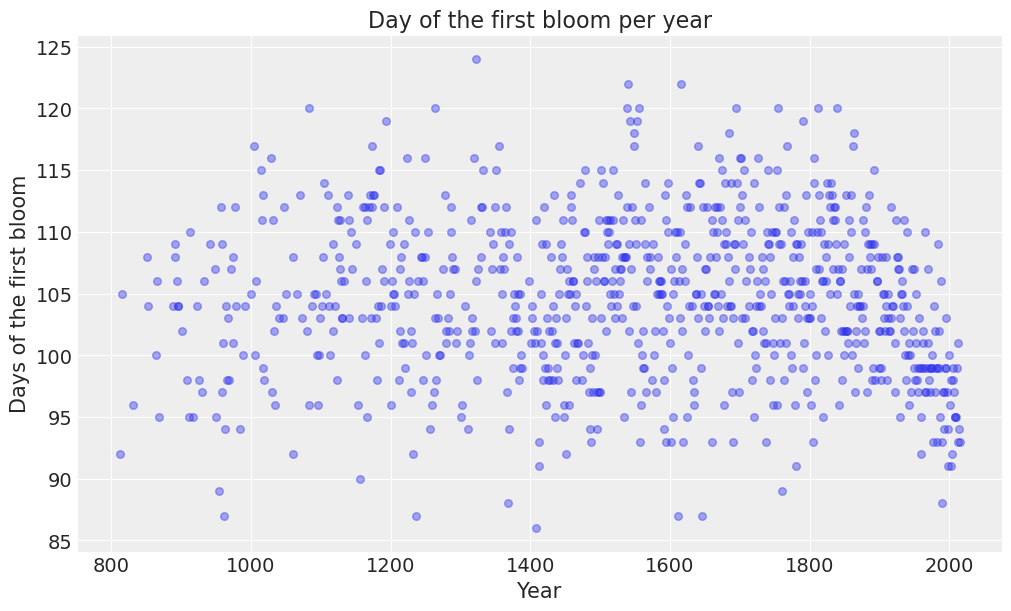

In [6]:
plot_scatter(data);

We can observe the day of the first bloom ranges between 85 and 125 approximately, which correspond to late March and early May respectively. On average, the first bloom occurs on the 105th day of the year, which is middle April.

## Determine knots

The spline will have 15 knots. These knots are the boundaries of the basis functions. These knots split the range of the `"year"` variable into 16 contiguous sections. The basis functions make up a piecewise continuous polynomial, and so they are enforced to meet at the knots. We use the default degree for each piecewise polynomial, which is 3. The result is known as a **cubic spline**.

Because of using quantiles and not having observations for all the years in the time window under study, the knots are distributed unevenly over the range of `"year"` in such a way that the same proportion of values fall between each section.

In [7]:
num_knots = 15
knots = np.quantile(data["year"], np.linspace(0, 1, num_knots))

In [8]:
def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", alpha=0.4)
    return ax

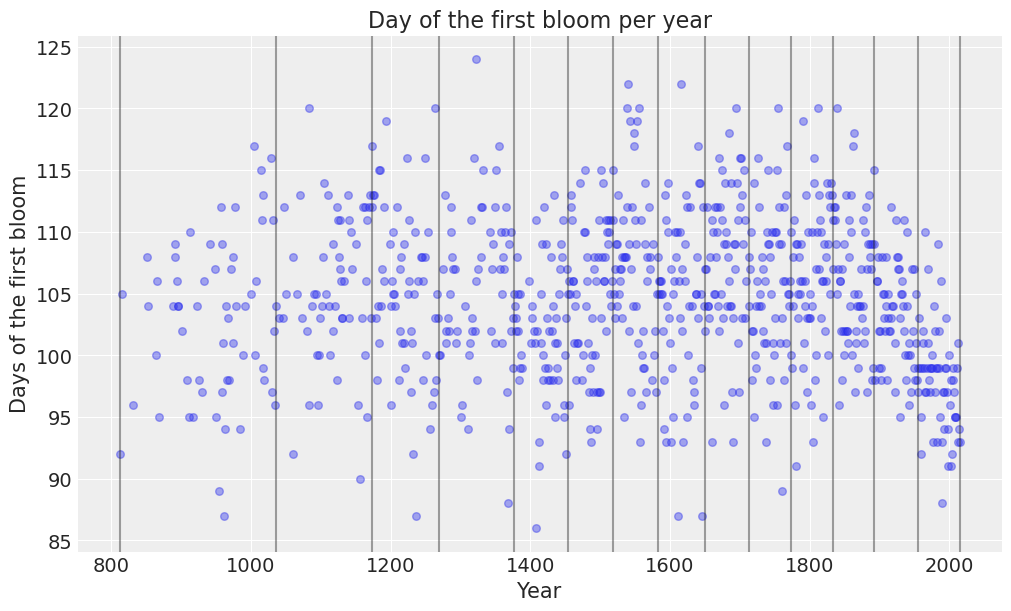

In [9]:
ax = plot_scatter(data)
plot_knots(knots, ax);

The previous chart makes it easy to see the knots, represented by the vertical lines, are spaced unevenly over the years.

## The model

The B-spline model we are about to create is simply a linear regression model with synthetic predictor variables. These predictors are the basis functions that are derived from the original `year` predictor.

In math notation, we usa a $\text{Normal}$ distribution for the conditional distribution of $Y$ when $X = x_i$, i.e. $Y_i$, the distribution of the day of the first bloom in a given year.

$$
Y_i \sim \text{Normal}(\mu_i, \sigma)
$$

So far, this looks like a regular linear regression model. The next line is where the spline comes into play:

$$
\mu_i = \alpha + \sum_{k=1}^K{w_kB_{k, i}}
$$

The line above tells that for each observation $i$, the mean is influenced by all the basis functions (going from $k=1$ to $k=K$), plus an intercept $\alpha$. The $w_k$ values in the summation are the regression coefficients of each of the basis functions, and the $B_k$ are the values of the basis functions.

Finally, we will be using the following priors

$$
\begin{aligned}
\alpha & \sim \text{Normal}(100, 10) \\
w_j & \sim \text{Normal}(0, 10)\\
\sigma & \sim \text{Exponential(1)}
\end{aligned}
$$

where $j$ indexes each of the contiguous sections given by the knots


In [10]:
# We only pass the internal knots to the `bs()` function.
iknots = knots[1:-1]

# Define dictionary of priors
priors = {
    "Intercept": bmb.Prior("Normal", mu=100, sigma=10),
    "common": bmb.Prior("Normal", mu=0, sigma=10), 
    "sigma": bmb.Prior("Exponential", lam=1)
}

# Define model
# The intercept=True means the basis also spans the intercept, as originally done in the book example.
model = bmb.Model("doy ~ bs(year, knots=iknots, intercept=True)", data, priors=priors)
model

Formula: doy ~ bs(year, knots=iknots, intercept=True)
Family name: Gaussian
Link: identity
Observations: 827
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 100, sigma: 10)
    bs(year, knots = iknots, intercept = True) ~ Normal(mu: 0, sigma: 10)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

Let's create a function to plot each of the basis functions in the model.

In [11]:
def plot_spline_basis(basis, year, figsize=(10, 6)):
    df = (
        pd.DataFrame(basis)
        .assign(year=year)
        .melt("year", var_name="basis_idx", value_name="value")
    )

    _, ax = plt.subplots(figsize=figsize)

    for idx in df.basis_idx.unique():
        d = df[df.basis_idx == idx]
        ax.plot(d["year"], d["value"])
    
    return ax

Below, we create a chart to visualize the b-spline basis. The overlap between the functions means that, at any given point in time, the regression function is influenced by more than one basis function. For example, if we look at the year 1200, we can see the regression line is going to be influenced mostly by the violet and brown functions, and to a lesser extent by the green and cyan ones. In summary, this is what enables us to capture local patterns in a smooth fashion.

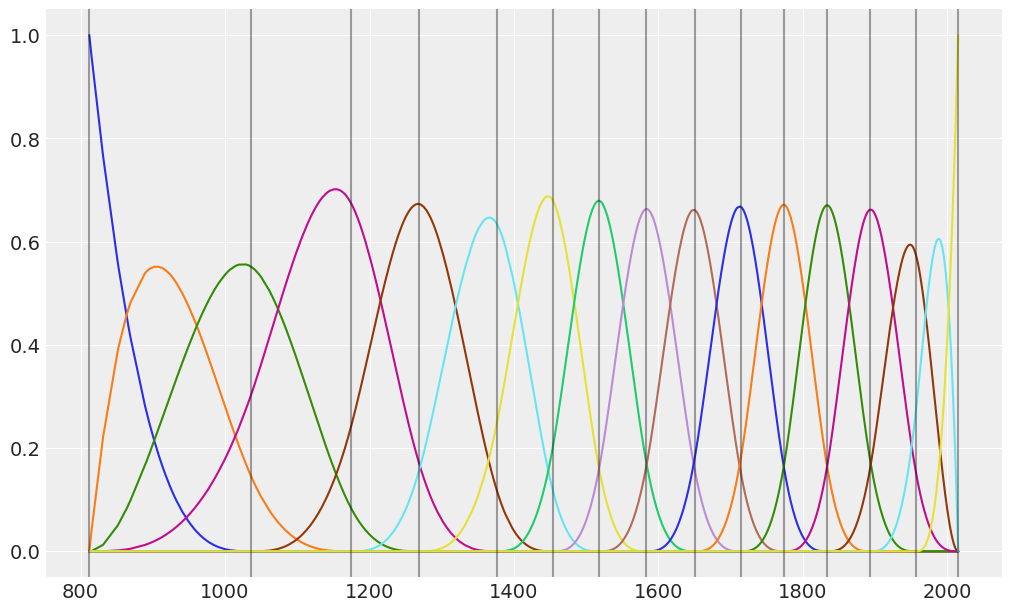

In [12]:
B = model._design.common["bs(year, knots = iknots, intercept = True)"]
ax = plot_spline_basis(B, data["year"].values)
plot_knots(knots, ax);

## Fit model

Now we fit the model. In Bambi, it is as easy as calling the `.fit()` method on the `Model` instance.

In [13]:
# The seed is to make results reproducible
idata = model.fit(random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(year, knots = iknots, intercept = True), doy_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


## Analisys of the results

It is always good to use `az.summary()` to verify parameter estimates as well as effective sample sizes and R hat values. In this case, the main goal is not to interpret the coefficients of the basis spline, but analyze the `ess` and `r_hat` diagnostics. In first place, effective sample sizes don't look impressively high. Most of them are between 300 and 700, which is low compared to the 2000 draws obtained. The only exception is the residual standard deviation `sigma`. Finally, the `r_hat` diagnostic is not always 1 for all the parameters, indicating there may be some issues with the mix of the chains.

In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,103.805,2.529,99.303,108.573,0.099,0.070,660.0,1152.0,1.0
"bs(year, knots = iknots, intercept = True)[0]",-3.448,3.927,-11.137,3.554,0.105,0.075,1391.0,2511.0,1.0
"bs(year, knots = iknots, intercept = True)[1]",-1.354,4.060,-8.853,6.198,0.106,0.075,1464.0,2344.0,1.0
"bs(year, knots = iknots, intercept = True)[2]",-1.412,3.736,-8.355,5.731,0.117,0.082,1028.0,2072.0,1.0
"bs(year, knots = iknots, intercept = True)[3]",4.318,2.975,-1.201,9.795,0.094,0.068,999.0,1508.0,1.0
"bs(year, knots = iknots, intercept = True)[4]",-1.283,3.044,-7.102,4.216,0.104,0.074,850.0,1763.0,1.0
"bs(year, knots = iknots, intercept = True)[5]",3.854,3.032,-1.587,9.411,0.102,0.072,879.0,1763.0,1.0
"bs(year, knots = iknots, intercept = True)[6]",-5.780,2.967,-11.063,0.173,0.103,0.073,836.0,1484.0,1.0
"bs(year, knots = iknots, intercept = True)[7]",7.393,2.919,2.099,12.941,0.099,0.070,871.0,1696.0,1.0
"bs(year, knots = iknots, intercept = True)[8]",-1.452,3.060,-7.093,4.460,0.103,0.073,891.0,1396.0,1.0


We can also use `az.plot_trace()` to visualize the marginal posteriors and the sampling paths. These traces show a stationary random pattern. If these paths were not random stationary, we would be concerned about the convergence of the chains.

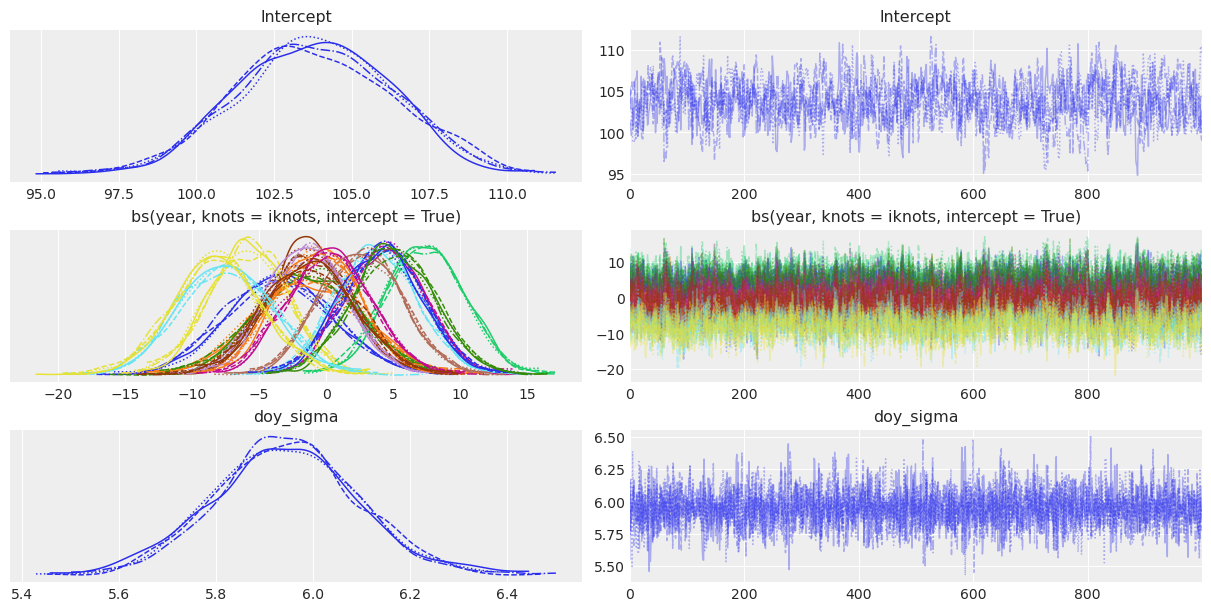

In [15]:
az.plot_trace(idata);

Now we can visualize the fitted basis functions. In addition, we include a thicker black line that represents the dot product between $B$ and $w$. This is the contribution of the b-spline to the linear predictor in the model.

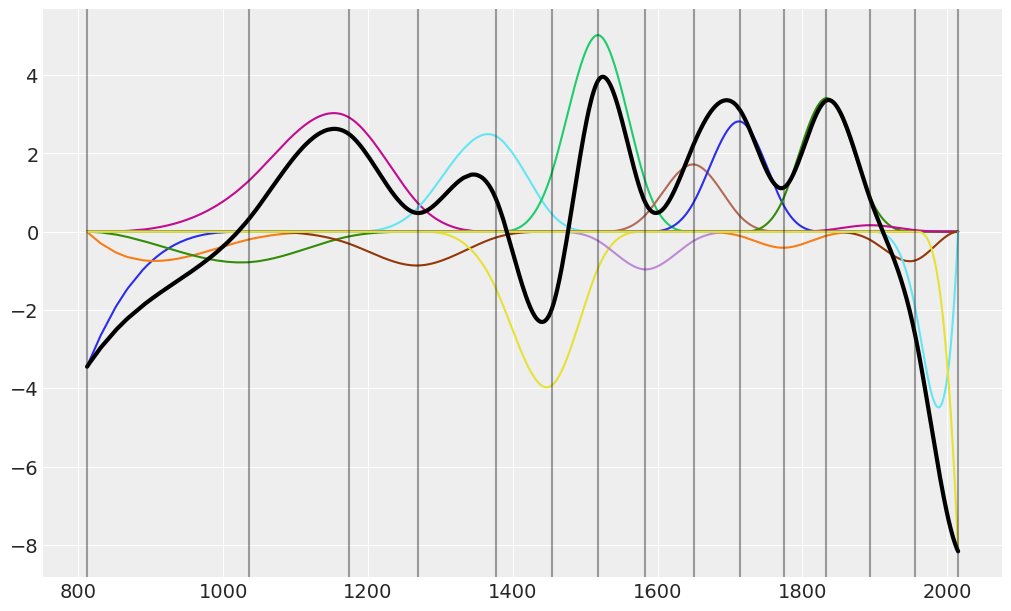

In [16]:
posterior_stacked = az.extract_dataset(idata)
wp = posterior_stacked["bs(year, knots = iknots, intercept = True)"].mean("sample").values

ax = plot_spline_basis(B * wp.T, data["year"].values)
ax.plot(data.year.values, np.dot(B, wp.T), color="black", lw=3)
plot_knots(knots, ax);

## Plot predictions and credible bands

Let's create a function to plot the predicted mean value as well as credible bands for it.

In [17]:
def plot_predictions(data, idata, model):
    # Create a test dataset with observations spanning the whole range of year
    new_data = pd.DataFrame({"year": np.linspace(data.year.min(), data.year.max(), num=500)})
    
    # Predict the day of first blossom
    model.predict(idata, data=new_data)

    posterior_stacked =  az.extract_dataset(idata)
    # Extract these predictions
    y_hat = posterior_stacked["doy_mean"]

    # Compute the mean of the predictions, plotted as a single line.
    y_hat_mean = y_hat.mean("sample")

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(y_hat, [0.03, 0.97], axis=1)

    # Plot obserevd data
    ax = plot_scatter(data)
    
    # Plot predicted line
    ax.plot(new_data["year"], y_hat_mean, color="firebrick")
    
    # Plot credibility bands
    ax.fill_between(new_data["year"], hdi_data[0], hdi_data[1], alpha=0.4, color="firebrick")
    
    # Add knots
    plot_knots(knots, ax)
    
    return ax

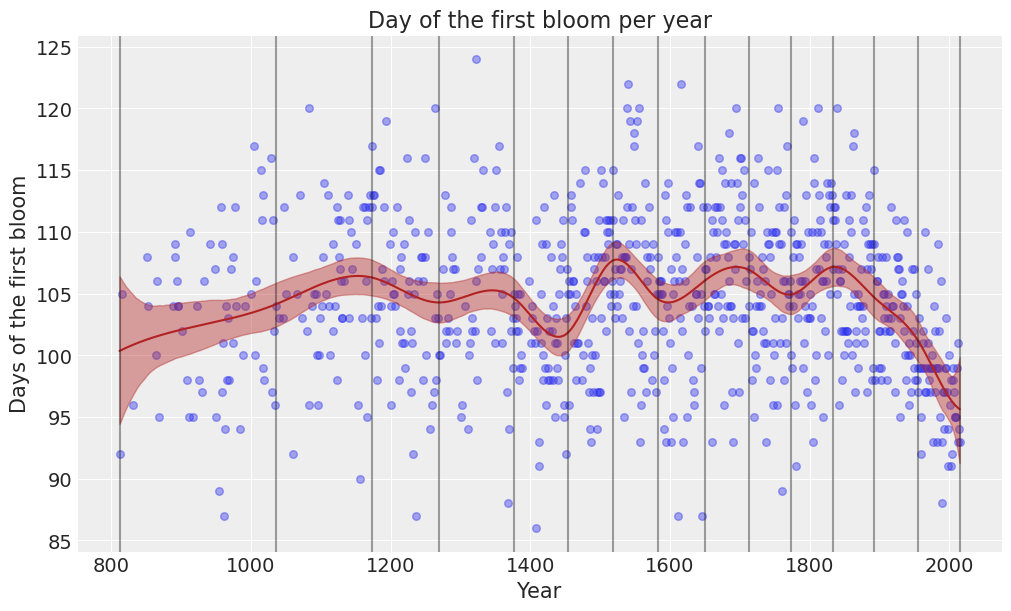

In [18]:
plot_predictions(data, idata, model);

## Advanced: Watch out the underlying design matrix

We can write linear regression models in matrix form as

$$
\mathbf{y} = \mathbf{X}\boldsymbol{\beta} 
$$

where $\mathbf{y}$ is the response column vector of shape $(n, 1)$. $\mathbf{X}$ is the **design matrix** that contains the values of the predictors for all the observations, of shape $(n, p)$. And $\boldsymbol{\beta}$ is the column vector of regression coefficients of shape $(n, 1)$.

Because it's not something that you're supposed to consult regularly, Bambi does not expose the design matrix. However, with a some knowledge of the internals, it is possible to have access to it:

In [19]:
np.round(model._design.common.design_matrix, 3)

array([[1.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [1.   , 0.96 , 0.039, ..., 0.   , 0.   , 0.   ],
       [1.   , 0.767, 0.221, ..., 0.   , 0.   , 0.   ],
       ...,
       [1.   , 0.   , 0.   , ..., 0.002, 0.097, 0.902],
       [1.   , 0.   , 0.   , ..., 0.   , 0.05 , 0.95 ],
       [1.   , 0.   , 0.   , ..., 0.   , 0.   , 1.   ]])

Let's have a look at its shape:

In [20]:
model._design.common.design_matrix.shape

(827, 18)

827 is the number of years we have data for, and 18 is the number of predictors/coefficients in the model. We have the first column of ones due to the `Intercept` term. Then, there are sixteen columns associated with the the basis functions. And finally, one extra column because we used `span_intercept=True` when calling the function `bs()` in the model formula.

Now we could compute the rank of the design matrix to check whether all the columns are linearly independent.

In [21]:
np.linalg.matrix_rank(model._design.common.design_matrix)

17

Since $\text{rank}(\mathbf{X})$ is smaller than the number of columns, we conclude the columns in $\mathbf{X}$ are not linearly independent. 

If we have a second look at our code, we are going to figure out we're spanning the intercept **twice**. The first time with the intercept term itself, and the second time in the spline basis.

This would have been a huge problem in a maximum likelihod estimation approach -- we would have obtained an error instead of some parameter estimates. However, since we are doing Bayesian modeling, our priors ensured we obtain our regularized parameter estimates and everything seemed to work pretty well. 

Nevertheless, we can still do better. Why would we want to span the intercept twice? Let's create and fit the model again, this time without spanning the intercept in the spline basis.

In [22]:
# Note we use the same priors
model_new = bmb.Model("doy ~ bs(year, knots=iknots)", data, priors=priors)
idata_new = model_new.fit(random_seed=7355608)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(year, knots = iknots), doy_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


And let's have a look at the summary

In [23]:
az.summary(idata_new)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,102.438,1.992,98.821,106.100,0.064,0.045,965.0,1338.0,1.01
"bs(year, knots = iknots)[0]",-0.941,3.978,-8.165,6.549,0.104,0.074,1453.0,2142.0,1.00
"bs(year, knots = iknots)[1]",0.330,3.151,-5.446,6.282,0.066,0.048,2300.0,2591.0,1.00
"bs(year, knots = iknots)[2]",5.595,2.675,0.643,10.640,0.075,0.053,1279.0,2224.0,1.00
"bs(year, knots = iknots)[3]",0.172,2.552,-4.675,4.836,0.066,0.047,1506.0,2375.0,1.00
"bs(year, knots = iknots)[4]",5.146,2.661,0.060,9.909,0.074,0.053,1276.0,2435.0,1.00
"bs(year, knots = iknots)[5]",-4.359,2.536,-9.353,0.213,0.068,0.048,1380.0,2095.0,1.00
"bs(year, knots = iknots)[6]",8.735,2.476,3.949,13.130,0.068,0.048,1308.0,2190.0,1.00
"bs(year, knots = iknots)[7]",-0.096,2.655,-5.326,4.674,0.071,0.050,1415.0,2361.0,1.00
"bs(year, knots = iknots)[8]",3.909,2.581,-0.920,8.736,0.068,0.048,1426.0,1966.0,1.00


There are a couple of things to remark here

* There are 16 coefficients associated with the b-spline now because we're not spanning the intercept.
* The ESS numbers have improved in all cases. Notice the sampler isn't raising any warning about low ESS.
* r_hat coefficeints are still 1.

We can also compare the sampling times:

In [24]:
idata.posterior.sampling_time

31.336991786956787

In [25]:
idata_new.posterior.sampling_time

28.54888606071472

Sampling times are the same in this particular example. But in general, we expect the sampler to run faster when there aren't structural dependencies in the design matrix.

And what about predictions?

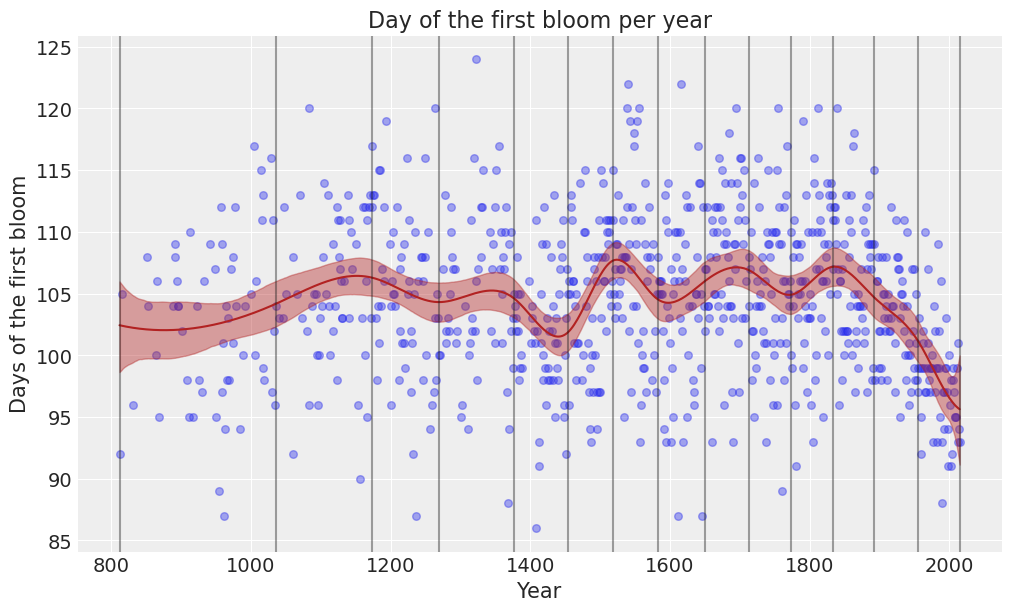

In [26]:
plot_predictions(data, idata_new, model_new);

And model comparison?

In [27]:
models_dict = {"Original": idata, "New": idata_new}
df_compare = az.compare(models_dict)
df_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
New,0,-2657.993432,16.091082,0.000000,1.0,21.175383,0.000000,False,log
Original,1,-2658.153269,16.469409,0.159836,0.0,21.180233,0.565825,False,log


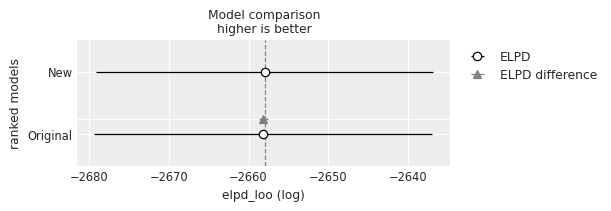

In [28]:
az.plot_compare(df_compare, insample_dev=False);

Finally let's check influential points according to the k-hat value

In [29]:
# Compute pointwise LOO
loo_1 = az.loo(idata, pointwise=True)
loo_2 = az.loo(idata_new, pointwise=True)

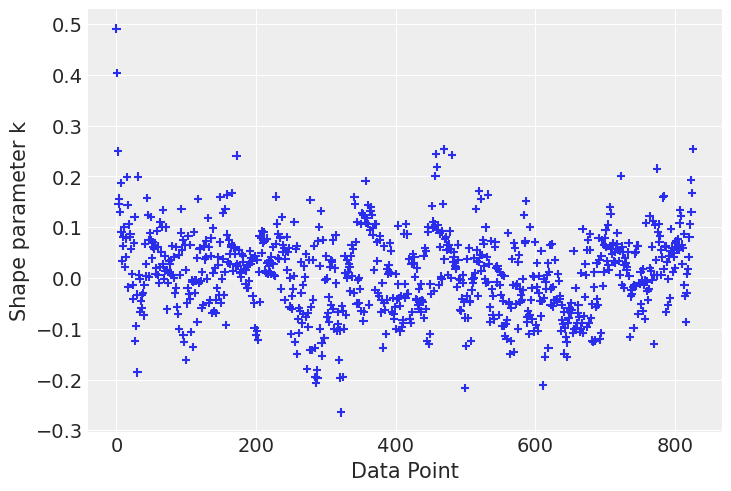

In [30]:
# plot kappa values
az.plot_khat(loo_1.pareto_k);

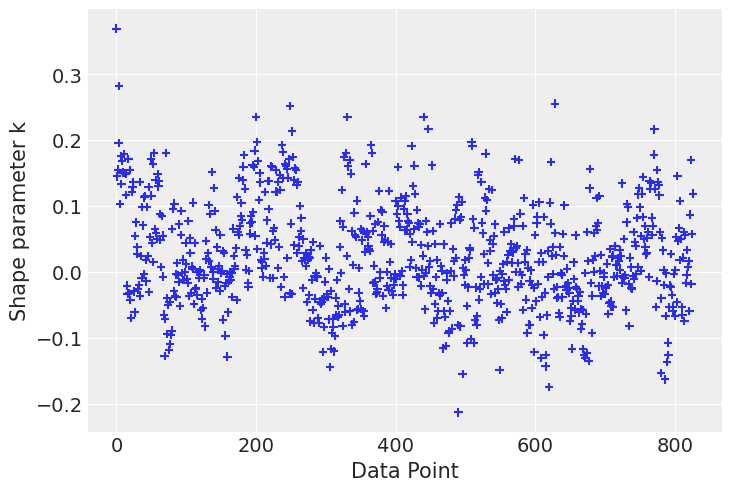

In [31]:
az.plot_khat(loo_2.pareto_k);

## Final comments

Another option could have been to use stronger priors on the coefficients associated with the spline functions. For example, the example written in PyMC uses $\text{Normal}(0, 3)$ priors on them instead of $\text{Normal}(0, 10)$.

In [32]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jun 16 2022

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.3.0

bambi     : 0.9.0
matplotlib: 3.5.1
arviz     : 0.13.0.dev0
sys       : 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
numpy     : 1.21.5
pandas    : 1.4.2

Watermark: 2.3.0

